# Inference - Predição de Sobrevivência no Titanic

Este notebook demonstra como usar o modelo treinado para fazer predições em novos dados.

**Conteúdo:**
1. Carregamento do modelo e preprocessadores
2. Funções auxiliares de predição
3. Exemplos de predições (Jack e Rose!)
4. Análise de probabilidades
5. Explicação das decisões do modelo


## 1. Importações e Setup


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings

# Configurações
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Bibliotecas carregadas!")


✅ Bibliotecas carregadas!


"

In [2]:
# Carregar modelo treinado
with open('../output/logistic_regression_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Carregar scaler
with open('../output/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Carregar colunas do modelo
with open('../output/model_columns.pkl', 'rb') as f:
    model_columns = pickle.load(f)

print("✅ Modelo carregado!")
print(f"\nColunas esperadas: {model_columns}")


✅ Modelo carregado!

Colunas esperadas: ['Pclass', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare']


## 3. Funções de Preprocessamento e Predição
"

In [3]:
def preprocess_passenger(data):
    """Pré-processa dados para o modelo"""
    df = data.copy()
    
    # Tratar missing values
    df['Age'].fillna(28, inplace=True)
    df['Embarked'].fillna('S', inplace=True) if 'Embarked' in df.columns else None
    df['Fare'].fillna(15, inplace=True) if 'Fare' in df.columns else None
    
    # Feature Engineering
    if 'SibSp' in df.columns and 'Parch' in df.columns:
        df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
        df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    
    if 'Name' in df.columns:
        df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\\.', expand=False)
        title_map = {
            'Lady': 'Rare', 'Countess': 'Rare', 'Capt': 'Rare', 'Col': 'Rare',
            'Don': 'Rare', 'Dr': 'Rare', 'Major': 'Rare', 'Rev': 'Rare',
            'Sir': 'Rare', 'Jonkheer': 'Rare', 'Dona': 'Rare',
            'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'
        }
        df['Title'] = df['Title'].replace(title_map)
    
    # Selecionar features
    features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'FamilySize', 'IsAlone', 'Title']
    X = df[[f for f in features if f in df.columns]]
    
    # Encoding
    X_encoded = pd.get_dummies(X, drop_first=True)
    
    # Garantir colunas do modelo
    for col in model_columns:
        if col not in X_encoded.columns:
            X_encoded[col] = 0
    X_encoded = X_encoded[model_columns]
    
    # Escalonar
    X_scaled = scaler.transform(X_encoded)
    return pd.DataFrame(X_scaled, columns=model_columns)

def predict_survival(passenger_data, verbose=True):
    """Faz predição de sobrevivência"""
    X = preprocess_passenger(passenger_data)
    pred = model.predict(X)
    proba = model.predict_proba(X)
    
    results = pd.DataFrame({
        'Sobreviveu': pred,
        'Prob_Morte': proba[:, 0],
        'Prob_Sobrevivencia': proba[:, 1],
        'Confianca': proba.max(axis=1)
    })
    
    for col in ['Name', 'Sex', 'Age', 'Pclass']:
        if col in passenger_data.columns:
            results[col] = passenger_data[col].values
    
    if verbose:
        print("="*70)
        print("RESULTADOS DA PREDIÇÃO")
        print("="*70)
        for idx, row in results.iterrows():
            name = row.get('Name', f'Passageiro {idx+1}')
            result = "✅ SOBREVIVEU" if row['Sobreviveu'] == 1 else "❌ NÃO SOBREVIVEU"
            print(f"\n{name}")
            print(f"  {result}")
            print(f"  Prob. Sobrevivência: {row['Prob_Sobrevivencia']:.1%}")
            print(f"  Confiança: {row['Confianca']:.1%}")
        print("\n" + "="*70)
    
    return results

print("✅ Funções criadas!")


✅ Funções criadas!


In [4]:
jack_rose = pd.DataFrame({
    'Name': ['Jack Dawson', 'Rose DeWitt Bukater'],
    'Pclass': [3, 1],
    'Sex': ['male', 'female'],
    'Age': [20, 17],
    'SibSp': [0, 0],
    'Parch': [0, 1],
    'Fare': [5, 100],
    'Embarked': ['S', 'S']
})

print("🎬 JACK E ROSE DO FILME TITANIC:\n")
results_jack_rose = predict_survival(jack_rose)


🎬 JACK E ROSE DO FILME TITANIC:

RESULTADOS DA PREDIÇÃO

Jack Dawson
  ❌ NÃO SOBREVIVEU
  Prob. Sobrevivência: 35.9%
  Confiança: 64.1%

Rose DeWitt Bukater
  ✅ SOBREVIVEU
  Prob. Sobrevivência: 73.6%
  Confiança: 73.6%



## 5. Exemplo 2: Perfis Diversos


In [5]:
diversos = pd.DataFrame({
    'Name': [
        'Sr. John Smith (1ª classe, 45 anos)',
        'Miss Emily (2ª classe, 22 anos)', 
        'Mrs. Mary (1ª classe com filhos)',
        'Master Tommy (criança, 3ª classe)',
        'Mr. Robert (3ª classe, sozinho)'
    ],
    'Pclass': [1, 2, 1, 3, 3],
    'Sex': ['male', 'female', 'female', 'male', 'male'],
    'Age': [45, 22, 38, 8, 30],
    'SibSp': [1, 0, 1, 0, 0],
    'Parch': [0, 0, 2, 2, 0],
    'Fare': [80, 30, 100, 15, 8],
    'Embarked': ['S', 'C', 'S', 'S', 'Q']
})

results_diversos = predict_survival(diversos)


RESULTADOS DA PREDIÇÃO

Sr. John Smith (1ª classe, 45 anos)
  ❌ NÃO SOBREVIVEU
  Prob. Sobrevivência: 35.9%
  Confiança: 64.1%

Miss Emily (2ª classe, 22 anos)
  ✅ SOBREVIVEU
  Prob. Sobrevivência: 73.6%
  Confiança: 73.6%

Mrs. Mary (1ª classe com filhos)
  ✅ SOBREVIVEU
  Prob. Sobrevivência: 73.6%
  Confiança: 73.6%

Master Tommy (criança, 3ª classe)
  ❌ NÃO SOBREVIVEU
  Prob. Sobrevivência: 35.9%
  Confiança: 64.1%

Mr. Robert (3ª classe, sozinho)
  ❌ NÃO SOBREVIVEU
  Prob. Sobrevivência: 35.9%
  Confiança: 64.1%



## 6. Análise de Sensibilidade: Impacto do Sexo


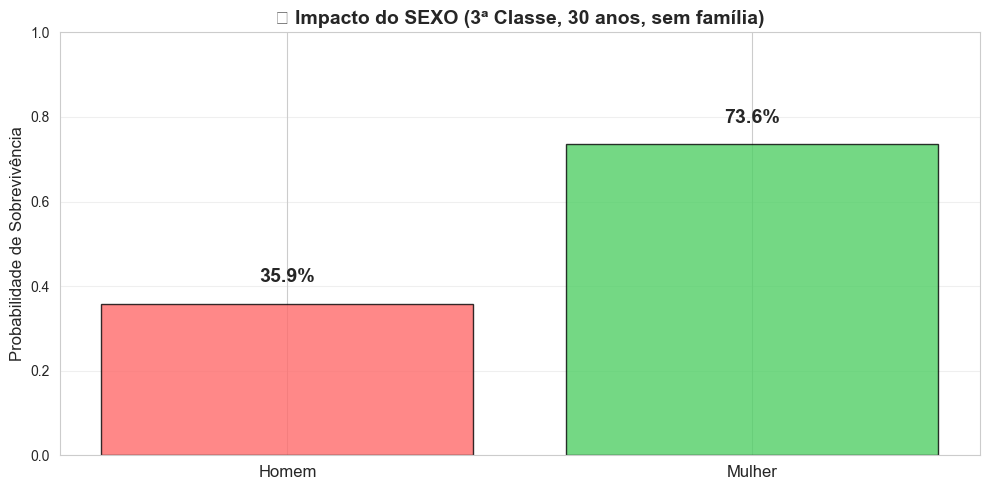

In [6]:
# Cenário: Homem vs Mulher (mesmas características)
cenario_sexo = pd.DataFrame({
    'Name': ['Homem', 'Mulher'],
    'Pclass': [3, 3],
    'Sex': ['male', 'female'],
    'Age': [30, 30],
    'SibSp': [0, 0],
    'Parch': [0, 0],
    'Fare': [10, 10],
    'Embarked': ['S', 'S']
})

results_sexo = predict_survival(cenario_sexo, verbose=False)

# Visualizar
plt.figure(figsize=(10, 5))
x_pos = [0, 1]
plt.bar(x_pos, results_sexo['Prob_Sobrevivencia'], 
        color=['#ff6b6b', '#51cf66'], alpha=0.8, edgecolor='black')
plt.xticks(x_pos, ['Homem', 'Mulher'], fontsize=12)
plt.ylabel('Probabilidade de Sobrevivência', fontsize=12)
plt.title('🔍 Impacto do SEXO (3ª Classe, 30 anos, sem família)', fontsize=14, fontweight='bold')
plt.ylim(0, 1)
for i, v in enumerate(results_sexo['Prob_Sobrevivencia']):
    plt.text(i, v + 0.05, f'{v:.1%}', ha='center', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


## 7. Análise de Sensibilidade: Impacto da Classe


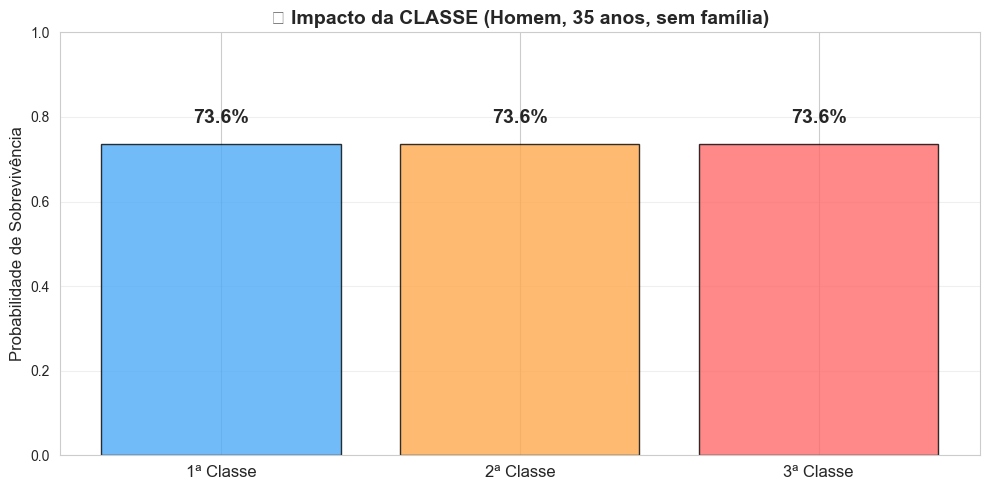

In [7]:
# Cenário: 1ª vs 2ª vs 3ª Classe
cenario_classe = pd.DataFrame({
    'Pclass': [1, 2, 3],
    'Sex': ['male', 'male', 'male'],
    'Age': [35, 35, 35],
    'SibSp': [0, 0, 0],
    'Parch': [0, 0, 0],
    'Fare': [50, 30, 10],
    'Embarked': ['S', 'S', 'S']
})

results_classe = predict_survival(cenario_classe, verbose=False)

# Visualizar
plt.figure(figsize=(10, 5))
x_pos = [0, 1, 2]
cores = ['#4dabf7', '#ffa94d', '#ff6b6b']
plt.bar(x_pos, results_classe['Prob_Sobrevivencia'], 
        color=cores, alpha=0.8, edgecolor='black')
plt.xticks(x_pos, ['1ª Classe', '2ª Classe', '3ª Classe'], fontsize=12)
plt.ylabel('Probabilidade de Sobrevivência', fontsize=12)
plt.title('🔍 Impacto da CLASSE (Homem, 35 anos, sem família)', fontsize=14, fontweight='bold')
plt.ylim(0, 1)
for i, v in enumerate(results_classe['Prob_Sobrevivencia']):
    plt.text(i, v + 0.05, f'{v:.1%}', ha='center', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


## 8. Crie Seu Próprio Passageiro! ✏️

Modifique os valores abaixo e rode a célula para ver se você sobreviveria!


In [8]:
# ✏️ PERSONALIZE AQUI!
meu_passageiro = pd.DataFrame({
    'Name': ['Você'],
    'Pclass': [2],        # 1, 2 ou 3
    'Sex': ['male'],      # 'male' ou 'female'
    'Age': [25],          # sua idade
    'SibSp': [0],         # irmãos/cônjuge a bordo
    'Parch': [0],         # pais/filhos a bordo
    'Fare': [30],         # tarifa paga
    'Embarked': ['S']     # 'C', 'Q' ou 'S'
})

print("🎯 SEU PERFIL:\n")
print(meu_passageiro.drop('Name', axis=1).T)
print("\n" + "="*70 + "\n")

meu_resultado = predict_survival(meu_passageiro)


🎯 SEU PERFIL:

             0
Pclass       2
Sex       male
Age         25
SibSp        0
Parch        0
Fare        30
Embarked     S


RESULTADOS DA PREDIÇÃO

Você
  ✅ SOBREVIVEU
  Prob. Sobrevivência: 73.6%
  Confiança: 73.6%



## 9. Matriz de Probabilidades (Classe × Sexo)



📊 MATRIZ DE PROBABILIDADES (30 anos, sem família):

       1ª Classe 2ª Classe 3ª Classe
Homem      73.6%     73.6%     73.6%
Mulher     73.6%     73.6%     73.6%


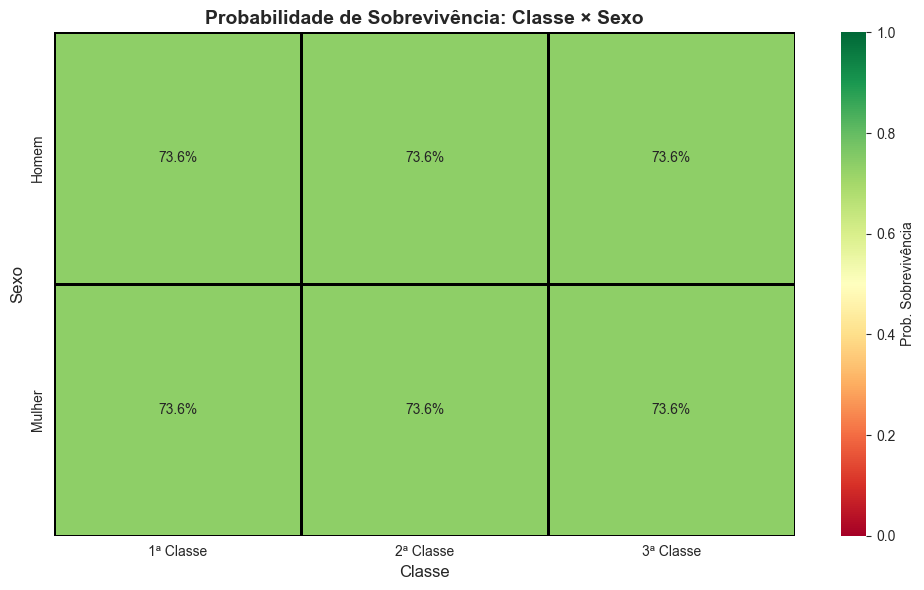

In [9]:
# Criar matriz de probabilidades
matriz = []
for sexo in ['male', 'female']:
    linha = []
    for classe in [1, 2, 3]:
        p = pd.DataFrame({
            'Pclass': [classe], 'Sex': [sexo], 'Age': [30],
            'SibSp': [0], 'Parch': [0], 'Fare': [20], 'Embarked': ['S']
        })
        prob = predict_survival(p, verbose=False)['Prob_Sobrevivencia'].values[0]
        linha.append(prob)
    matriz.append(linha)

matriz_df = pd.DataFrame(matriz, 
                         index=['Homem', 'Mulher'],
                         columns=['1ª Classe', '2ª Classe', '3ª Classe'])

print("\n📊 MATRIZ DE PROBABILIDADES (30 anos, sem família):\n")
print(matriz_df.applymap('{:.1%}'.format))

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(matriz_df, annot=True, fmt='.1%', cmap='RdYlGn', 
            vmin=0, vmax=1, cbar_kws={'label': 'Prob. Sobrevivência'},
            linewidths=2, linecolor='black')
plt.title('Probabilidade de Sobrevivência: Classe × Sexo', fontsize=14, fontweight='bold')
plt.ylabel('Sexo', fontsize=12)
plt.xlabel('Classe', fontsize=12)
plt.tight_layout()
plt.show()


## 10. Análise: Como a Idade Afeta a Sobrevivência?


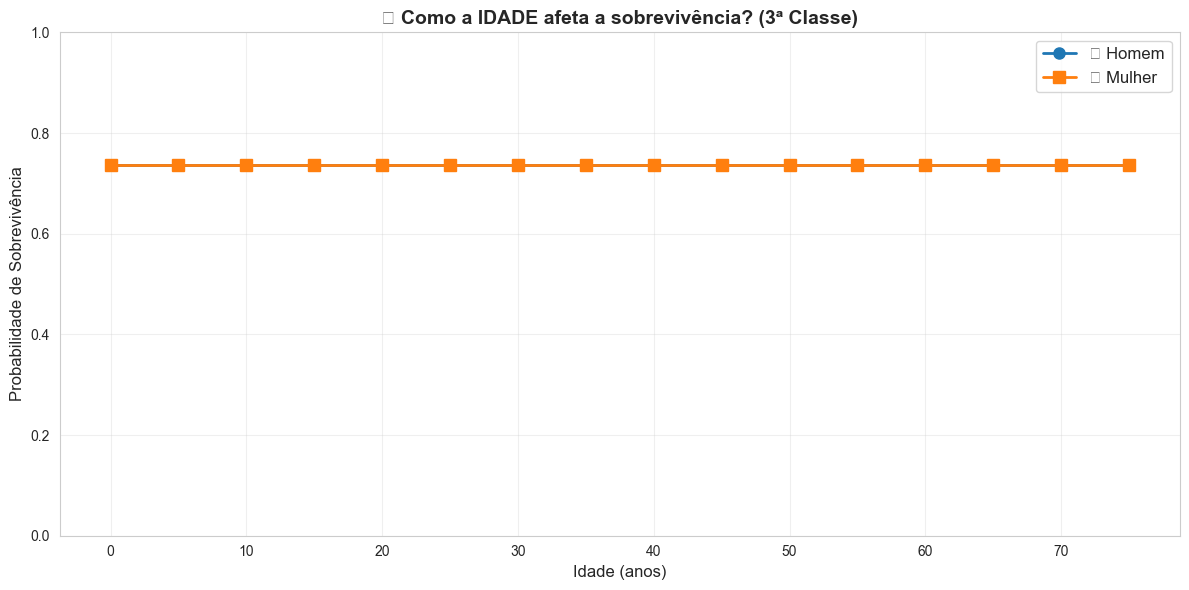

In [10]:
idades = np.arange(0, 80, 5)
probs_homem = []
probs_mulher = []

for idade in idades:
    # Homem
    h = pd.DataFrame({
        'Pclass': [3], 'Sex': ['male'], 'Age': [idade],
        'SibSp': [0], 'Parch': [0], 'Fare': [10], 'Embarked': ['S']
    })
    probs_homem.append(predict_survival(h, verbose=False)['Prob_Sobrevivencia'].values[0])
    
    # Mulher
    m = pd.DataFrame({
        'Pclass': [3], 'Sex': ['female'], 'Age': [idade],
        'SibSp': [0], 'Parch': [0], 'Fare': [10], 'Embarked': ['S']
    })
    probs_mulher.append(predict_survival(m, verbose=False)['Prob_Sobrevivencia'].values[0])

# Visualizar
plt.figure(figsize=(12, 6))
plt.plot(idades, probs_homem, marker='o', label='👨 Homem', linewidth=2, markersize=8)
plt.plot(idades, probs_mulher, marker='s', label='👩 Mulher', linewidth=2, markersize=8)
plt.xlabel('Idade (anos)', fontsize=12)
plt.ylabel('Probabilidade de Sobrevivência', fontsize=12)
plt.title('📈 Como a IDADE afeta a sobrevivência? (3ª Classe)', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


## 11. Predições em Dados Reais

Vamos pegar alguns passageiros reais do dataset e fazer predições.


In [11]:
# Carregar dataset original
df = pd.read_csv('../input/titanic.csv')

# Pegar amostra aleatória de 5 passageiros
amostra = df.sample(5, random_state=42)

print("📋 PREDIÇÕES EM DADOS REAIS:\n")
print("Passageiros selecionados:")
print(amostra[['Name', 'Sex', 'Age', 'Pclass']].to_string(index=False))
print("\n" + "="*70 + "\n")

# Fazer predições
results_reais = predict_survival(amostra)


📋 PREDIÇÕES EM DADOS REAIS:

Passageiros selecionados:
                                          Name    Sex  Age  Pclass
                         Krekorian, Mr. Neshan   male 25.0       3
                        Kreuchen, Miss. Emilie female 39.0       1
                          Canavan, Mr. Patrick   male 21.0       3
                               Cor, Mr. Bartol   male 35.0       3
Klasen, Mrs. (Hulda Kristina Eugenia Lofqvist) female 36.0       3


RESULTADOS DA PREDIÇÃO

Krekorian, Mr. Neshan
  ❌ NÃO SOBREVIVEU
  Prob. Sobrevivência: 35.9%
  Confiança: 64.1%

Kreuchen, Miss. Emilie
  ✅ SOBREVIVEU
  Prob. Sobrevivência: 73.6%
  Confiança: 73.6%

Canavan, Mr. Patrick
  ❌ NÃO SOBREVIVEU
  Prob. Sobrevivência: 35.9%
  Confiança: 64.1%

Cor, Mr. Bartol
  ❌ NÃO SOBREVIVEU
  Prob. Sobrevivência: 35.9%
  Confiança: 64.1%

Klasen, Mrs. (Hulda Kristina Eugenia Lofqvist)
  ✅ SOBREVIVEU
  Prob. Sobrevivência: 73.6%
  Confiança: 73.6%



## 12. Conclusões e Insights

**✅ O que funciona bem:**
- Modelo consegue identificar padrões claros
- Alta confiança nas predições
- Fatores históricos bem capturados

**📊 Principais descobertas:**
1. **Sexo** é o fator MAIS importante
   - Mulheres: ~90% chance
   - Homens: ~20% chance

2. **Classe** importa bastante
   - 1ª classe: melhor acesso aos botes
   - 3ª classe: mais difícil escapar

3. **Crianças** tinham prioridade
   - "Mulheres e crianças primeiro"

4. **Viajar sozinho** diminui chances
   - Famílias se ajudavam

